# Notebook test de modelos

## Imports

In [1]:
import json
import ollama
import evaluate
from bert_score import score as bertscore
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import sys
import os

# Agregar el directorio raíz del proyecto al sys.path
notebook_dir = os.getcwd()  # Ruta del notebook actual
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # Subir un nivel al directorio raíz
sys.path.append(project_root)
# Importar la función desde rule_phrase_system.py
from src.models.rule_phrase_system import generar_resumen_pdf

c:\Users\Musatom\Documents\Universidad\Master\TFM\vtfm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuración y definición de funciones

In [2]:
# Configuración
MODELOS = ["mistral", "gemma3:4b", "gemma3:12b", "llama3.1:8b", "deepseek-r1:7b"]
N_PARTIDOS = 6

# Rutas
DATASET_PATH = "../data/dataset/dataset_updated.json"

In [3]:
# Cargar resúmenes reales (referencias)
def cargar_referencias(ids_partidos):
    with open(DATASET_PATH, "r", encoding="utf-8") as f:
        dataset = json.load(f)
    referencias = {}
    for id in ids_partidos:
        resumen_ref_raw = dataset[id]["pdf_sections"].get("resumen_final", "")
        resumen_ref = str(resumen_ref_raw).strip()
        if resumen_ref:
            referencias[id] = resumen_ref
    return referencias

# Generar outputs a partir de contenido
def generar_outputs_concatenado(modelo, contenidos):
    resumen_arbitro = contenidos["arbitro"]
    resumen_asistente_1 = contenidos["asistente_1"]
    resumen_asistente_2 = contenidos["asistente_2"]
    resumen_cuarto_arbitro = contenidos["cuarto_arbitro"]

    prompt = f"""
            Eres un experto en arbitraje de fútbol. Resume el contenido que te voy a proporcionar en español, de manera profesional y concisa:

            **Árbitro**:
            {resumen_arbitro}

            **Asistente 1**:
            {resumen_asistente_1}

            **Asistente 2**:
            {resumen_asistente_2}

            **Cuarto árbitro**:
            {resumen_cuarto_arbitro}
            """
    respuesta = ollama.chat(model=modelo, messages=[
        {'role': 'system', 'content': 'Eres un experto en arbitraje de fútbol y redacción profesional en español.'},
        {'role': 'user', 'content': prompt}
    ])
    return respuesta['message']['content']

# Evaluación con ROUGE
def evaluar_rouge(predicciones, referencias):
    rouge = evaluate.load("rouge")
    return rouge.compute(predictions=predicciones, references=referencias)

# Evaluación con BERTScore
def evaluar_bertscore(predicciones, referencias):
    P, R, F1 = bertscore(predicciones, referencias, lang="es")
    return {
        "bert_precision": P.mean().item(),
        "bert_recall": R.mean().item(),
        "bert_f1": F1.mean().item()
    }

## Evaluación

In [4]:
resumenes_pdf = generar_resumen_pdf()
ids = list(resumenes_pdf.keys())[:N_PARTIDOS]
partidos = {id: resumenes_pdf[id] for id in ids}
referencias_dict = cargar_referencias(ids)
referencias_lista = [referencias_dict[i] for i in ids]

# Evaluación
resultados_modelos = {}
predicciones_modelos = {}

for modelo in MODELOS:
    predicciones = []
    for id in tqdm(ids, desc=f"Generando ({modelo})"):
        contenido = partidos[id]
        salida = generar_outputs_concatenado(modelo, contenido)
        predicciones.append(salida)
    predicciones_modelos[modelo] = predicciones
    rouge_scores = evaluar_rouge(predicciones, referencias_lista)
    bert_scores = evaluar_bertscore(predicciones, referencias_lista)
    resultados_modelos[modelo] = {
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "BERTScore-P": bert_scores["bert_precision"],
        "BERTScore-R": bert_scores["bert_recall"],
        "BERTScore-F1": bert_scores["bert_f1"],
    }

Generando (deepseek-r1:7b): 100%|██████████| 6/6 [01:04<00:00, 10.75s/it]


## Resultados gráficos

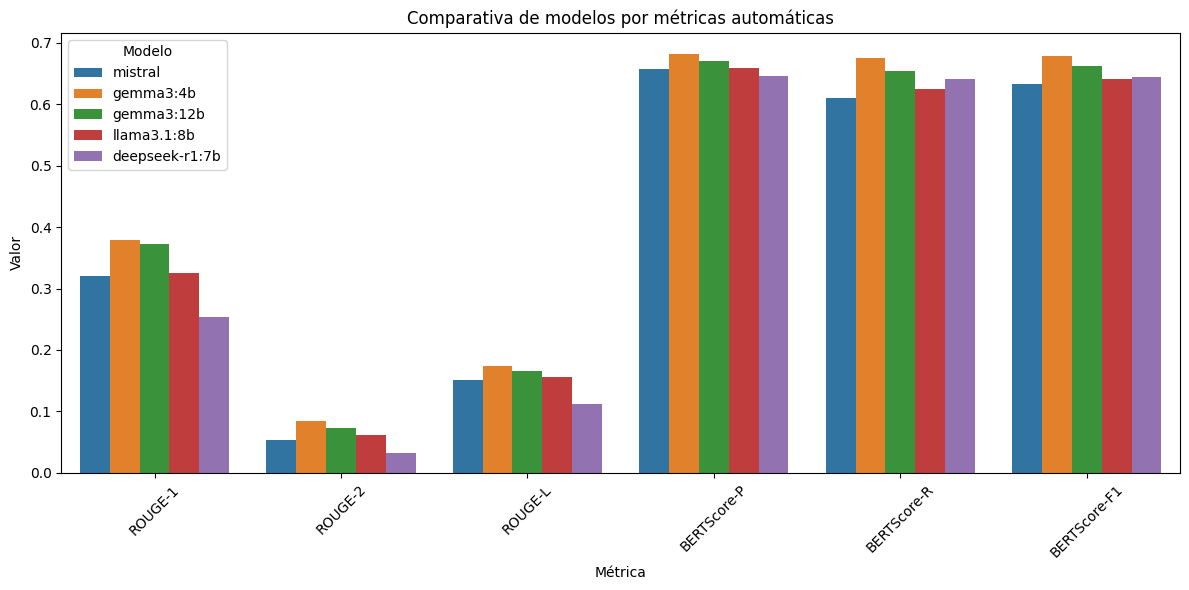

In [5]:
# Visualización
df_resultados = pd.DataFrame(resultados_modelos).T.reset_index().rename(columns={"index": "Modelo"})
df_resultados_melt = df_resultados.melt(id_vars=["Modelo"], var_name="Métrica", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados_melt, x="Métrica", y="Valor", hue="Modelo")
plt.title("Comparativa de modelos por métricas automáticas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Añadir comentarios de los resultados

## Evaluación humana

In [ ]:
#TODO: Añadir evaluación humana